# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [ ]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

## Download data from Kaggle
(Show dir structure before downloading the data)

In [ ]:
#!kaggle competitions download -c isic-2024-challenge --path ./data/


  0%|          | 0.00/2.00G [00:00<?, ?B/s]
  0%|          | 1.00M/2.00G [00:00<07:37, 4.69MB/s]
  0%|          | 3.00M/2.00G [00:00<04:43, 7.56MB/s]
  0%|          | 4.00M/2.00G [00:00<04:44, 7.54MB/s]
  0%|          | 5.00M/2.00G [00:00<04:45, 7.50MB/s]
  0%|          | 6.00M/2.00G [00:00<04:46, 7.48MB/s]
  0%|          | 7.00M/2.00G [00:01<04:46, 7.47MB/s]
  0%|          | 8.00M/2.00G [00:01<04:47, 7.43MB/s]
  0%|          | 9.00M/2.00G [00:01<04:47, 7.45MB/s]
  0%|          | 10.0M/2.00G [00:01<04:46, 7.46MB/s]
  1%|          | 11.0M/2.00G [00:01<04:48, 7.40MB/s]
  1%|          | 12.0M/2.00G [00:01<04:46, 7.44MB/s]
  1%|          | 13.0M/2.00G [00:01<04:46, 7.45MB/s]
  1%|          | 14.0M/2.00G [00:01<04:47, 7.42MB/s]
  1%|          | 15.0M/2.00G [00:02<04:48, 7.39MB/s]
  1%|          | 16.0M/2.00G [00:02<04:47, 7.42MB/s]
  1%|          | 17.0M/2.00G [00:02<04:47, 7.42MB/s]
  1%|          | 18.0M/2.00G [00:02<04:46, 7.44MB/s]
  1%|          | 19.0M/2.00G [00:02<04:46, 7.44MB/s]
 

In [ ]:
#! cd ./data/ | unzip isic-2024-challenge.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
%pwd

'd:\\Momaz\\AWS_ML\\cancerClassification'

In [ ]:
# Explore the structure of the hdf5 file
import h5py

full_img_path = "data/isic-2024-challenge/test-image.hdf5"

with h5py.File(path, "r")as hdf:

    # Print all groups
    print("Keys: %s" % hdf.keys())
    # You can also loop over the keys to explore deeper levels
    for key in hdf.keys():
        print(f"\nKey: {key}")
        # Get the object
        obj = hdf[key]
        
        if isinstance(obj, h5py.Group):
            print("Group:")
            for subkey in obj.keys():
                print(f"  {subkey}")
        elif isinstance(obj, h5py.Dataset):
            print("Dataset:")
            print(f"  Shape: {obj.shape}")
            print(f"  Data type: {obj.dtype}")
            print(f"  Data: {obj[...]}")  # Print the data (optional)

Keys: <KeysViewHDF5 ['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740']>

Key: ISIC_0015657
Dataset:
  Shape: ()
  Data type: |S3318
  Data: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x8d\x00\x8d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x9

## Create training and validation splits from the original dataset

We'll use the meetdata contained in the CSV file to create a data partition containing a given number of images. With this we'll only use a sample or chunk from the original data so the training and HPO jobs do not get to expensive. From this newly created chubk we' ll create 2 hdf5 files, one for each training and validation split. For testing we'll use the originally provided hdf5 file w. 3 images.

In [ ]:
# FOLLOWING CODE AFTER DOWNLOADING ORIGINAL DATASET
#CREATE A WAY TO AVOID DOWNLOADING AND DECOMPRESSING THE FULL DATASET,
        #INSTEAD, UPLOAD ONLY THE NEWLY CREATED HDF5 FILES AND TEST HDF5

Read the CSV file and create splits using that data so we can use IDs to retrieve image data.
Load just the columns of interest to avoid memory usage

In [ ]:
full_meta_path = "data/isic-2024-challenge/train-metadata.csv"

In [ ]:
cols_of_interest = ["isic_id", "target"]

train_meta_df = pd.read_csv(full_meta_path, usecols=cols_of_interest)

In [ ]:
len(train_meta_df)

401059

In [ ]:
# Count the number of malignant cases
num_malignant = len(train_meta_df[train_meta_df["target"] == 1])
num_malignant

393

Our original dataset suffers a problem of class imbalance as the number of malignant cases is considerably less than the number of  beningn cases, we'll try to address this to achieve better generalixation from our models. Also, we'll extract a total of 1,000 images for training and validating our models.

In [ ]:
malignant_ids = train_meta_df[train_meta_df["target"] == 1]["isic_id"].tolist()
records_ids = []
# To retrieve all the malignant cases
records_ids.extend(malignant_ids)

num_records = 1000

for i in train_meta_df["isic_id"]:
    count = len(records_ids)
    if count >= num_records:
        break
    if i not in records_ids:
        records_ids.append(i)

In [ ]:
len(records_ids)

1000

In [ ]:
# check that we have uniquevalues
len(set(records_ids))

1000

In [ ]:
# Create a df for our partition so we can use 'target' to stratify the splits
partition_df = train_meta_df[train_meta_df["isic_id"].isin(records_ids)]
partition_df.shape

(1000, 2)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(partition_df.isic_id,
                                                  partition_df.target,
                                                  test_size=0.2,
                                                  stratify=partition_df.target)

### Create HDF5 files for each split

In [ ]:
import h5py
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import io
import time


full_image_path = "data/isic-2024-challenge/train-image.hdf5"

In [ ]:
def create_hdf5_split(records_array, file_path, target_file):
    with h5py.File(file_path, 'r') as file:
        keys_list = list(file.keys())
        records_list = list(records_array)
        with h5py.File(target_file, 'w') as new_file:
            for key in keys_list:
                if key in records_list:
                    data = file[key][()]
                    new_file.create_dataset(key, data=data)
            
            records_written = len(new_file.keys())

    print(f"Succesfully wrote {records_written} records in {target_file}")

In [ ]:
val_img_path = "data/isic-2024-challenge/val_split-image.hdf5"

create_hdf5_split(X_val, full_image_path, val_img_path)

Succesfully wrote 200 rcords in data/isic-2024-challenge/val_split-image.hdf5


In [ ]:
%%time
train_img_path = "data/isic-2024-challenge/train_split-image.hdf5"

create_hdf5_split(X_train, full_image_path, train_img_path)

In [ ]:
import h5py
import numpy as np
from PIL import Image
import io
from tqdm import tqdm
val_img_path = "data/isic-2024-challenge/val_split-image.hdf5"

def read_images(file_path):
    '''Function to read image data from a HDF5 file.
    Params:
    file_path: str, the file path to the HDF5 file.
    return: dict, a dictionary in the form of {Image ID: numpy array}"'''
    with h5py.File(file_path, 'r') as file:
        ids_list = list(file.keys())
        images = {}
        for img_id in tqdm(ids_list):
            # Extract the image data
            image_data = file[img_id][()] #retrieve the entire data from each dataset
            image = Image.open(io.BytesIO(image_data))
            images[img_id] = np.array(image)

    return images


100%|██████████| 200/200 [00:00<00:00, 655.37it/s]


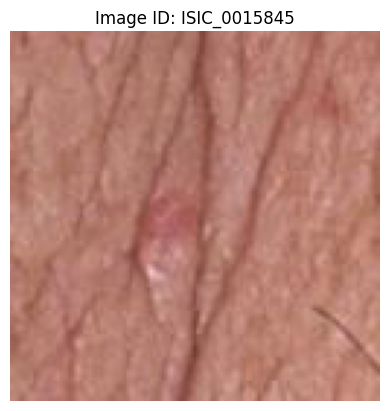

In [ ]:
import matplotlib.pyplot as plt

# Read the images from the HDF5 file
images = read_images(val_img_path)

# Access the first image in the dictionary
first_img_id, first_img_array = next(iter(images.items()))

# Plot the first image
plt.figure()
plt.imshow(first_img_array)
plt.title(f"Image ID: {first_img_id}")
plt.axis('off')
plt.show()

#### The function to read file from hdf5 files needs to be moved tp the rtaining script

In [ ]:
def read_images(file_path):
    '''Function to read image data from a HDF5 file.
    Params:
    file_path: str, the file path to the HDF5 file.
    return: dict, a dictionary in the form of {Image ID: numpy array}"'''
    with h5py.File(file_path, 'r') as file:
        ids_list = list(file.keys())
        images = {}
        for img_id in tqdm(ids_list):
            # Extract the image data
            image_data = file[img_id][()] #retrieve the entire data from each dataset
            image = Image.open(io.BytesIO(image_data))
            images[img_id] = np.array(image)

    return images


In [ ]:
%%time
train_images = read_images(full_image_path)

  0%|          | 0/401059 [00:00<?, ?it/s]


NameError: name 'np' is not defined

In [ ]:
len(train_images)

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
#TODO: Declare your HP ranges, metrics etc.

In [ ]:
#TODO: Create estimators for your HPs

estimator = # TODO: Your estimator here

tuner = # TODO: Your HP tuner here

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit() # TODO: Remember to include your data channels

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

estimator = # TODO: Your estimator here

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()